<a href="https://colab.research.google.com/github/Haadi-kp/Image_Colourization/blob/main/Colab_Notebooks/Image_Colorization_With_GANs_21_12_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Image Colorization With GANs**





## **1. Downloading and Processing the data**









In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create the destination folder if it doesn't exist
!mkdir -p /content/datas


In [ ]:

# Unzip files into the 'datas' folder
!unzip /content/drive/MyDrive/image_colouring/ImageNetDataset.zip -d /content/datas


Streaming output truncated to the last 5000 lines.
  inflating: /content/datas/00900/054653537039094.jpg  
  inflating: /content/datas/00900/07272256002875288.jpg  
  inflating: /content/datas/00900/075874938728387464.jpg  
  inflating: /content/datas/00900/084355288443908.jpg  
  inflating: /content/datas/00900/0938813935621416.jpg  
  inflating: /content/datas/00900/1655568257304816.jpg  
  inflating: /content/datas/00900/17337161967825.jpg  
  inflating: /content/datas/00900/185287956232336.jpg  
  inflating: /content/datas/00900/1898108151581965.jpg  
  inflating: /content/datas/00900/204089788662087.jpg  
  inflating: /content/datas/00900/2464974905916646.jpg  
  inflating: /content/datas/00900/262262197475642.jpg  
  inflating: /content/datas/00900/2677013029370365.jpg  
  inflating: /content/datas/00900/2823587208350367.jpg  
  inflating: /content/datas/00900/2846489896468567.jpg  
  inflating: /content/datas/00900/300747621842155.jpg  
  inflating: /content/datas/00900/33507644

In [ ]:
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from matplotlib import image
from matplotlib import pyplot as plt
import os
from tensorflow import keras
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.applications import InceptionV3

In [ ]:
# The batch size we'll use for training
batch_size = 64

# Size of the image required to train our model
img_size = 120

# Define the maximum number of folders and images to process
max_folders = 50  # Use only 50 folders
images_per_folder = 50  # Use only 50 images per folder

master_dir = '/content/datas'
x = []
y = []

# Get and sort folder names
all_folders = sorted([folder for folder in os.listdir(master_dir) if os.path.isdir(os.path.join(master_dir, folder))])


processed_folders = 0

for folder_name in all_folders[:max_folders]:
    folder_path = os.path.join(master_dir, folder_name)
    print(f"{processed_folders + 1}: Processing folder: {folder_name}")

    processed_images = 0  # Counter to track processed images in the folder
    for image_file in os.listdir(folder_path):
        if processed_images >= images_per_folder:  # Stop after 50 images
            break
        image_path = os.path.join(folder_path, image_file)
        try:
            # Open the image and resize
            rgb_image = Image.open(image_path).resize((img_size, img_size))
            rgb_array = np.asarray(rgb_image) / 255.0  # Normalize RGB

            # Convert the RGB image to grayscale
            gray_image = rgb_image.convert('L')  # Convert to grayscale
            gray_array = np.asarray(gray_image).reshape((img_size, img_size, 1)) / 255.0  # Normalize grayscale

            # Append grayscale and RGB arrays
            x.append(gray_array)
            y.append(rgb_array)

            processed_images += 1  # Increment the image counter
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")

    processed_folders += 1  # Increment the folder counter

# Train-test splitting
train_x, test_x, train_y, test_y = train_test_split(np.array(x), np.array(y), test_size=0.1)

# Construct tf.data.Dataset object
dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
dataset = dataset.batch(batch_size)


1: Processing folder: 00000
2: Processing folder: 00001
3: Processing folder: 00002
4: Processing folder: 00003
5: Processing folder: 00004
6: Processing folder: 00005
7: Processing folder: 00006
8: Processing folder: 00007
9: Processing folder: 00008
10: Processing folder: 00009
11: Processing folder: 00010
12: Processing folder: 00011
13: Processing folder: 00012
14: Processing folder: 00013
15: Processing folder: 00014
16: Processing folder: 00015
17: Processing folder: 00016
18: Processing folder: 00017
19: Processing folder: 00018
20: Processing folder: 00019
21: Processing folder: 00020
22: Processing folder: 00021
23: Processing folder: 00022
24: Processing folder: 00023
25: Processing folder: 00024
26: Processing folder: 00025
27: Processing folder: 00026
28: Processing folder: 00027
29: Processing folder: 00028
30: Processing folder: 00029
31: Processing folder: 00030
32: Processing folder: 00031
33: Processing folder: 00032
34: Processing folder: 00033
35: Processing folder: 


## **2. The GAN**

In this section, we'll create our GAN model step-by-step with Keras. First, we'll implement the generator then the discriminator and finally the loss functions required by both of them.



### **A. Generator**



In [ ]:
def get_generator_model():

    inputs = tf.keras.layers.Input( shape=( img_size , img_size , 1 ) )

    conv1 = tf.keras.layers.Conv2D( 16 , kernel_size=( 5 , 5 ) , strides=1 )( inputs )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )
    conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )
    conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )

    conv2 = tf.keras.layers.Conv2D( 32 , kernel_size=( 5 , 5 ) , strides=1)( conv1 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )
    conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )
    conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )

    conv3 = tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1 )( conv2 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )
    conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )
    conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )

    bottleneck = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='tanh' , padding='same' )( conv3 )

    concat_1 = tf.keras.layers.Concatenate()( [ bottleneck , conv3 ] )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_1 )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_3 )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_3 )

    concat_2 = tf.keras.layers.Concatenate()( [ conv_up_3 , conv2 ] )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_2 )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_2 )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_2 )

    concat_3 = tf.keras.layers.Concatenate()( [ conv_up_2 , conv1 ] )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( concat_3 )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( conv_up_1 )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 3 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu')( conv_up_1 )

    model = tf.keras.models.Model( inputs , conv_up_1 )
    return model



### **B. Discriminator**



In [ ]:
def get_discriminator_model():
    layers = [
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7 , 7 ) , strides=1 , activation='relu' , input_shape=( 120 , 120 , 3 ) ),
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7, 7 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense( 512, activation='relu'  )  ,
        tf.keras.layers.Dense( 128 , activation='relu' ) ,
        tf.keras.layers.Dense( 16 , activation='relu' ) ,
        tf.keras.layers.Dense( 1 , activation='sigmoid' )
    ]
    model = tf.keras.models.Sequential( layers )
    return model



### **C. Loss Functions**





In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) - tf.random.uniform( shape=real_output.shape , maxval=0.1 ) , real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output) + tf.random.uniform( shape=fake_output.shape , maxval=0.1  ) , fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output , real_y):
    real_y = tf.cast( real_y , 'float32' )
    return mse( fake_output , real_y )

generator_optimizer = tf.keras.optimizers.Adam( 0.0005 )
discriminator_optimizer = tf.keras.optimizers.Adam( 0.0005 )

generator = get_generator_model()
discriminator = get_discriminator_model()



## **3. Training The GAN**




In [ ]:
@tf.function
def train_step( input_x , real_y ):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate an image -> G( x )
        generated_images = generator( input_x , training=True)
        # Probability that the given image is real -> D( x )
        real_output = discriminator( real_y, training=True)
        # Probability that the given image is the one generated -> D( G( x ) )
        generated_output = discriminator(generated_images, training=True)

        # L2 Loss -> || y - G(x) ||^2
        gen_loss = generator_loss( generated_images , real_y )
        # Log loss for the discriminator
        disc_loss = discriminator_loss( real_output, generated_output )

    #tf.keras.backend.print_tensor( tf.keras.backend.mean( gen_loss ) )
    #tf.keras.backend.print_tensor( gen_loss + disc_loss )

    # Compute the gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Optimize with Adam
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [ ]:
num_epochs = 120

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    iteration = 0  # Counter for iterations

    # Iterate through the dataset
    for input_x, real_y in dataset:
        # Perform a training step
        gen_loss, disc_loss = train_step(input_x, real_y)

        # Log every 20th iteration
        if iteration % 10 == 0:
            print(f"Iteration {iteration}, Generator Loss: {gen_loss:.4f}, Discriminator Loss: {disc_loss:.4f}")
        iteration += 1





    # Save model checkpoints periodically
    if (e + 1) % 20 == 0:  # Save every 10 epochs
        generator.save(f"generator_epoch_{e + 1}.h5")
        discriminator.save(f"discriminator_epoch_{e + 1}.h5")
        print(f"Model checkpoints saved for epoch {e + 1}")



Epoch 1/120
Iteration 0, Generator Loss: 0.0293, Discriminator Loss: 0.9749
Iteration 10, Generator Loss: 0.0271, Discriminator Loss: 0.7299
Iteration 20, Generator Loss: 0.0238, Discriminator Loss: 1.1999
Iteration 30, Generator Loss: 0.0162, Discriminator Loss: 0.9009
Epoch 2/120
Iteration 0, Generator Loss: 0.0194, Discriminator Loss: 1.1391
Iteration 10, Generator Loss: 0.0189, Discriminator Loss: 0.7460
Iteration 20, Generator Loss: 0.0186, Discriminator Loss: 0.6623
Iteration 30, Generator Loss: 0.0133, Discriminator Loss: 0.9168
Epoch 3/120
Iteration 0, Generator Loss: 0.0164, Discriminator Loss: 0.6683
Iteration 10, Generator Loss: 0.0170, Discriminator Loss: 0.6690
Iteration 20, Generator Loss: 0.0176, Discriminator Loss: 1.2633
Iteration 30, Generator Loss: 0.0121, Discriminator Loss: 0.7361
Epoch 4/120
Iteration 0, Generator Loss: 0.0154, Discriminator Loss: 0.7409
Iteration 10, Generator Loss: 0.0163, Discriminator Loss: 0.6864
Iteration 20, Generator Loss: 0.0168, Discrimi


## **4. Results**




In [ ]:
# Ensure the generator is compiled before saving
generator.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    loss='mse',  # Use Mean Squared Error or a loss suitable for your task
    metrics=['accuracy']
)

# Save the generator model to a single HDF5 file
generator_file_path = '/content/drive/MyDrive/saved_model/finetune_1_generator_model.h5'
generator.save(generator_file_path)
print(f"Generator model saved to {generator_file_path}")

# Ensure the discriminator is compiled before saving
discriminator.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    loss='binary_crossentropy',  # Use Binary Crossentropy or a loss suitable for your task
    metrics=['accuracy']
)

# Save the discriminator model to a single HDF5 file
discriminator_file_path = '/content/drive/MyDrive/saved_model/finetune_1_discriminator_model.h5'
discriminator.save(discriminator_file_path)
print(f"Discriminator model saved to {discriminator_file_path}")


Generator model saved to /content/drive/MyDrive/saved_model/generator_model2.h5
Discriminator model saved to /content/drive/MyDrive/saved_model/discriminator_model2.h5


In [ ]:
import tensorflow as tf

# File paths for the saved models
generator_file_path = '/content/drive/MyDrive/saved_model/generator_model2.h5'
discriminator_file_path = '/content/drive/MyDrive/saved_model/discriminator_model2.h5'

# Load the models
generator = tf.keras.models.load_model(generator_file_path)
discriminator = tf.keras.models.load_model(discriminator_file_path)

print("Generator and Discriminator models loaded successfully.")


Generator and Discriminator models loaded successfully.


In [ ]:


# # Ensure generator model is initialized

# # Load trained weights if available
# # generator.load_weights("path_to_model_weights.h5")

# Visualize results for testing data
for i in range(len(test_x)):
    try:
        # Prepare grayscale input
        test_image = test_x[i].reshape(1, 120, 120, 1)  # Reshape to match model input

        # Generate colorized output
        colorized_output = generator(test_image).numpy()

        # Visualize the input, colorized output, and ground truth
        plt.figure(figsize=(15, 5))

        # Grayscale Input
        or_image = plt.subplot(1, 3, 1)
        or_image.set_title('Grayscale Input', fontsize=16)
        plt.imshow(test_x[i].reshape((120, 120)), cmap='gray')
        plt.axis('off')

        # Colorized Output
        in_image = plt.subplot(1, 3, 2)
        colorized_img = Image.fromarray((colorized_output[0] * 255).astype('uint8')).resize((1024, 1024))
        in_image.set_title('Colorized Output', fontsize=16)
        plt.imshow(colorized_img)
        plt.axis('off')

        # Ground Truth
        ou_image = plt.subplot(1, 3, 3)
        ground_truth_img = Image.fromarray((test_y[i] * 255).astype('uint8')).resize((1024, 1024))
        ou_image.set_title('Ground Truth', fontsize=16)
        plt.imshow(ground_truth_img)
        plt.axis('off')

        plt.show()

    except Exception as e:
        print(f"Error processing image {i + 1}: {e}")


In [ ]:
from io import BytesIO


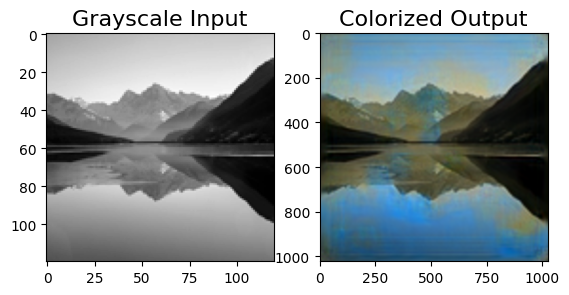

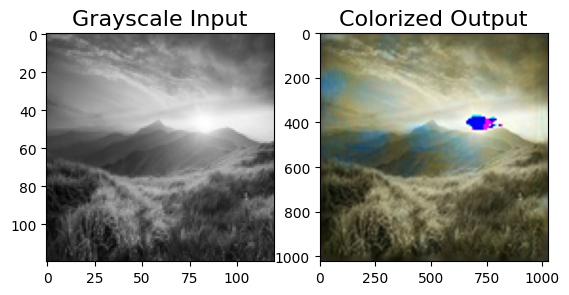

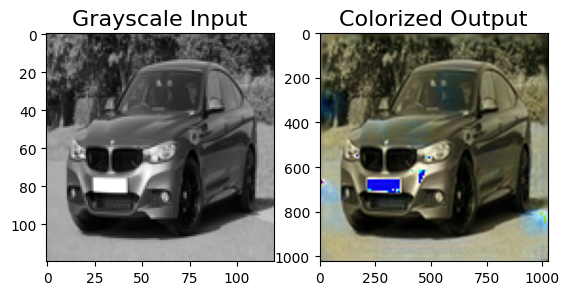

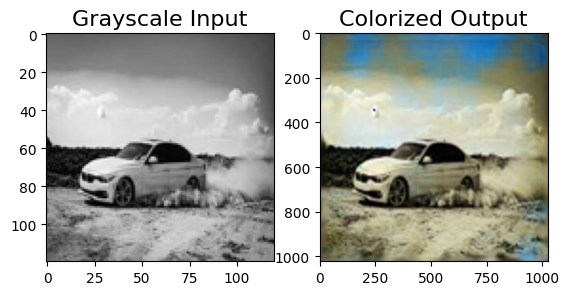

In [ ]:
import requests
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Define a function to download and process an image from a URL
def process_image_from_url(url, target_size=(120, 120)):
    response = requests.get(url)
    if response.status_code == 200:
        # Open the image from the response
        image = Image.open(BytesIO(response.content)).convert("L")  # Convert to grayscale
        # Resize to the model's expected input size
        image = image.resize(target_size)
        # Normalize the image
        image_array = np.asarray(image) / 255.0
        # Add batch and channel dimensions
        return image_array.reshape(1, target_size[0], target_size[1], 1)
    else:
        raise Exception(f"Failed to fetch image from URL: {response.status_code}")

# List of image URLs
image_urls = [
    "https://images.pexels.com/photos/346529/pexels-photo-346529.jpeg?cs=srgb&dl=pexels-bri-schneiter-28802-346529.jpg&fm=jpg",
    "https://media.istockphoto.com/id/517188688/photo/mountain-landscape.jpg?s=612x612&w=0&k=20&c=A63koPKaCyIwQWOTFBRWXj_PwCrR4cEoOw2S9Q7yVl8=",
    "https://images.pexels.com/photos/170811/pexels-photo-170811.jpeg?cs=srgb&dl=pexels-mikebirdy-170811.jpg&fm=jpg",
    "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSzrMllu8JUuu4lUfJ21cmtXbQZXiN2oK_Z0M5UZPhM8D8Yek9KZPJnWst-bm7ml2G_ydE&usqp=CAU"
    # Add more image URLs here
]

# Iterate over the image URLs and test the model
for i, url in enumerate(image_urls):
    try:
        # Process the image
        test_image = process_image_from_url(url)

        # Generate colorized output
        colorized_output = generator(test_image).numpy()

        # Visualize the input and output
        plt.figure(figsize=(10, 10))

        # Grayscale Input
        or_image = plt.subplot(1, 3, 1)
        or_image.set_title('Grayscale Input', fontsize=16)
        plt.imshow(test_image[0].reshape((120, 120)), cmap='gray')

        # Colorized Output
        in_image = plt.subplot(1, 3, 2)
        output_image = Image.fromarray((colorized_output[0] * 255).astype('uint8')).resize((1024, 1024))
        in_image.set_title('Colorized Output', fontsize=16)
        plt.imshow(output_image)

        plt.show()

    except Exception as e:
        print(f"Error processing image {i + 1}: {e}")


Therefore, the overwhelming reslts depicts the power of GANs and the disruption which can be broght through them.